In [1]:
#assigning patients to a "good" or "bad" outcome class and turn this into a classification problem.
import pandas as pd
import os

In [2]:
radiomics_path = "D:\work\ingham-medphys-coding-master\ingham-medphys-coding-master\data\HN_Radiomics.csv"
clinical_data_path = "D:\work\ingham-medphys-coding-master\ingham-medphys-coding-master\data\HN_ClinicalData.csv"

In [4]:
#Prepare all the data into the data framework
df_clinical_data=pd.read_csv(clinical_data_path)
df_radiomics=pd.read_csv(radiomics_path)
#attact GTV data
df_gtv_radiomics = df_radiomics[df_radiomics["Structure"].str.startswith("GTV")]
df_gtv_radiomics = df_gtv_radiomics.groupby("id")[["VoxelVolume", "SurfaceArea"]].sum()
#merge data into the clininal data
df = df_clinical_data.merge(df_gtv_radiomics, on="id")

In [5]:
Train_Data=df[df["dataset"]=="train"]
Test_Data=df[df["dataset"]=="test"]

In [6]:
#to transfer the problem into the classification problem (the mean of the overall_survival_in_days is near 5 years)
#overall_survival_data>1825 is good, otherwise is bad
import numpy as np
np.mean(df["overall_survival_in_days"])
for i, row in df.iterrows():
    if df.at[i,'overall_survival_in_days']>1825:
        df.at[i,'overall_survival_in_days'] = 1
    else: 
        df.at[i,'overall_survival_in_days'] = 0

In [7]:
Train_Data=df[df["dataset"]=="train"]
Test_Data=df[df["dataset"]=="test"]

In [101]:
Test_Data['overall_survival_in_days'].head()

1     1
13    0
16    1
21    1
22    0
Name: overall_survival_in_days, dtype: int64

In [61]:
#Data cleaning, fill null, delete null and object data to int
df_Train_Data = Train_Data.drop(['overall_hpv_p16_status', 'pretreat_hb_in_mmolperlitre'],axis=1)
df_Test_Data = Test_Data.drop(['overall_hpv_p16_status', 'pretreat_hb_in_mmolperlitre'],axis=1)
df_Train_Data['performance_status_ecog'].fillna(df_Train_Data['performance_status_ecog'].value_counts().index[0], inplace=True)
df_Test_Data['performance_status_ecog'].fillna(df_Test_Data['performance_status_ecog'].value_counts().index[0], inplace=True)
df_train=df_Train_Data
df_test=df_Test_Data

In [62]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
cols = ('index_tumour_location', 'biological_sex', 'ajcc_stage', 'cancer_surgery_performed', 'chemotherapy_given')
# process columns, apply LabelEncoder to categorical features into numeric data
for c in cols:
    df_train[c] = labelencoder.fit_transform(df_train[c])
    df_test[c] = labelencoder.fit_transform(df_test[c])

In [258]:
x_train = df_train.drop(['id', 'dataset', 'overall_survival_in_days'], axis=1)
Y_train = df_train["overall_survival_in_days"]
x = x_train.values
y = Y_train.values

In [259]:
x_test = df_test.drop(['id', 'dataset', 'overall_survival_in_days'], axis=1)
Y_test = df_test["overall_survival_in_days"]
inputx = x_test.values
outputy = Y_test.values

In [260]:
#modeling
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [261]:
def classification_model(model, data, x_train, Y_train):
  #Fit the model:
  model.fit(x_train,Y_train)
  
  #Make predictions on training set:
  predictions = model.predict(x_train)
  
  #Print accuracy
  accuracy = accuracy_score(predictions,Y_train)
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(n_splits=5).split(data)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (x_train.iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = Y_train.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(x_train.iloc[test,:], Y_train.iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Fit the model again so that it can be refered outside the function:
  model.fit(x_train,Y_train) 

In [262]:
logmodel=LogisticRegression()
classification_model(logmodel,df_train,x_train,Y_train)
predictions = logmodel.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 97.059%
Cross-Validation Score : 80.952%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.476%
Cross-Validation Score : 87.857%
Cross-Validation Score : 88.286%
Accuracy : 77.143%


d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-pa

In [263]:
ranmodel = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(ranmodel,df_train,x_train,Y_train)
predictions = ranmodel.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 91.176%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 88.286%
Accuracy : 77.143%


In [264]:
decmodel = DecisionTreeClassifier()
classification_model(decmodel,df_train,x_train,Y_train)
predictions = decmodel.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 80.952%
Cross-Validation Score : 85.635%
Cross-Validation Score : 86.726%
Cross-Validation Score : 86.381%
Accuracy : 77.143%


In [265]:
clf = lgb.LGBMClassifier()
classification_model(clf,df_train,x_train,Y_train)
predictions = clf.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 89.286%
Accuracy : 80.000%


In [266]:
#improve the results with fewer features
cols = list(x_train.columns)
featimp = pd.Series(ranmodel.feature_importances_,index = cols).sort_values(ascending=False)
print(featimp)

local_recurrence_in_days                          0.169449
distant_metastases_in_days                        0.146374
locoregional_recurrence_in_days                   0.126282
recurrence_metastatic_free_survival_in_days       0.097770
event_overall_survival                            0.081829
SurfaceArea                                       0.053427
age_at_diagnosis                                  0.047334
clin_n                                            0.039644
VoxelVolume                                       0.037795
event_recurrence_metastatic_free_survival         0.027855
ajcc_stage                                        0.025197
radiotherapy_total_treat_time                     0.024075
clin_t                                            0.023136
radiotherapy_refgydose_perfraction_highriskgtv    0.017093
event_locoregional_recurrence                     0.016505
event_local_recurrence                            0.015360
radiotherapy_number_fractions_highriskgtv         0.0135

In [267]:
index=featimp[:20]

In [268]:
x_train=df_train[featimp[:10].index]
x_test=df_test[featimp[:10].index]
x_train.info()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 136
Data columns (total 10 columns):
local_recurrence_in_days                       102 non-null int64
distant_metastases_in_days                     102 non-null int64
locoregional_recurrence_in_days                102 non-null int64
recurrence_metastatic_free_survival_in_days    102 non-null int64
event_overall_survival                         102 non-null int64
SurfaceArea                                    102 non-null float64
age_at_diagnosis                               102 non-null int64
clin_n                                         102 non-null int64
VoxelVolume                                    102 non-null float64
event_recurrence_metastatic_free_survival      102 non-null int64
dtypes: float64(2), int64(8)
memory usage: 13.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 1 to 133
Data columns (total 10 columns):
local_recurrence_in_days                       35 non-null int64
distant_met

In [269]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)
scaled_x_train = pd.DataFrame(X_train , index=x_train.index, columns=x_train.columns)
scaled_x_test = pd.DataFrame(X_test , index=x_test.index, columns=x_test.columns)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [270]:
ranmodel = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(ranmodel,df_train,scaled_x_train,Y_train)
predictions = ranmodel.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 95.098%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 88.286%
Accuracy : 80.000%


In [271]:
clf = lgb.LGBMClassifier()
classification_model(clf,df_train,scaled_x_train,Y_train)
predictions = clf.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 89.286%
Accuracy : 85.714%


In [272]:
decmodel = DecisionTreeClassifier()
classification_model(decmodel,df_train,scaled_x_train,Y_train)
predictions = decmodel.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 83.333%
Cross-Validation Score : 85.556%
Cross-Validation Score : 86.667%
Cross-Validation Score : 85.333%
Accuracy : 77.143%


In [273]:
logmodel=LogisticRegression(random_state = 42,max_iter= 150)
classification_model(logmodel,df_train,scaled_x_train,Y_train)
predictions = logmodel.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 94.118%
Cross-Validation Score : 85.714%
Cross-Validation Score : 90.476%
Cross-Validation Score : 90.317%
Cross-Validation Score : 92.738%
Cross-Validation Score : 92.190%
Accuracy : 91.429%


d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-pa

In [105]:
train_X, test_X, train_Y, test_Y = train_test_split(x_train, Y_train, test_size = 0.2, random_state = 0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(test_X)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """


In [90]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics# add validation dataset

Using TensorFlow backend.


In [174]:
classifier = models.Sequential()
#add input layer and first hidden layer
classifier.add(layers.Dense(output_dim = 6, kernel_initializer = "uniform", activation = "relu", input_dim = 10))
#add 2nd hidden layer
classifier.add(layers.Dense(output_dim = 6, kernel_initializer = "uniform", activation = "relu"))
classifier.add(layers.Dense(output_dim = 1, kernel_initializer = "uniform", activation = "sigmoid"))
classifier.compile(optimizer = "Adam", loss ="binary_crossentropy", metrics = ["accuracy"])

d:\app\python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=10, units=6)`
  This is separate from the ipykernel package so we can avoid doing imports until
d:\app\python\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=6)`
  """
d:\app\python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="sigmoid", units=1)`
  


In [178]:
#classifier.fit(scaled_x_train,Y_train, batch_size = 10, epochs = 100)
kf = KFold(n_splits=5).split(scaled_x_train)
for train, test in kf:
    # Filter training data
    train_predictors = (scaled_x_train.iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = Y_train.iloc[train]
    
    # Training the algorithm using the predictors and target.
    classifier.fit(train_predictors, train_target, batch_size = 10, epochs = 100)
classifier.fit(scaled_x_train, Y_train, batch_size = 10, epochs = 100)

Epoch 1/100
81/81 [==============================] - 4s 47ms/step - loss: 0.6930 - acc: 0.5679
Epoch 2/100
81/81 [==============================] - 0s 197us/step - loss: 0.6926 - acc: 0.5802
Epoch 3/100
81/81 [==============================] - 0s 271us/step - loss: 0.6920 - acc: 0.5802
Epoch 4/100
81/81 [==============================] - 0s 160us/step - loss: 0.6911 - acc: 0.5802
Epoch 5/100
81/81 [==============================] - 0s 135us/step - loss: 0.6896 - acc: 0.5802
Epoch 6/100
81/81 [==============================] - 0s 160us/step - loss: 0.6875 - acc: 0.5802
Epoch 7/100
81/81 [==============================] - 0s 197us/step - loss: 0.6844 - acc: 0.6049
Epoch 8/100
81/81 [==============================] - 0s 197us/step - loss: 0.6805 - acc: 0.6914
Epoch 9/100
81/81 [==============================] - 0s 222us/step - loss: 0.6754 - acc: 0.8272
Epoch 10/100
81/81 [==============================] - 0s 209us/step - loss: 0.6681 - acc: 0.8889
Epoch 11/100
81/81 [====================

81/81 [==============================] - 0s 123us/step - loss: 0.1098 - acc: 0.9630
Epoch 86/100
81/81 [==============================] - 0s 135us/step - loss: 0.1094 - acc: 0.9630
Epoch 87/100
81/81 [==============================] - 0s 111us/step - loss: 0.1087 - acc: 0.9630
Epoch 88/100
81/81 [==============================] - 0s 135us/step - loss: 0.1082 - acc: 0.9630
Epoch 89/100
81/81 [==============================] - 0s 123us/step - loss: 0.1071 - acc: 0.9630
Epoch 90/100
81/81 [==============================] - 0s 111us/step - loss: 0.1071 - acc: 0.9630
Epoch 91/100
81/81 [==============================] - 0s 123us/step - loss: 0.1063 - acc: 0.9630
Epoch 92/100
81/81 [==============================] - 0s 111us/step - loss: 0.1055 - acc: 0.9630
Epoch 93/100
81/81 [==============================] - 0s 123us/step - loss: 0.1050 - acc: 0.9630
Epoch 94/100
81/81 [==============================] - 0s 111us/step - loss: 0.1045 - acc: 0.9630
Epoch 95/100
81/81 [=======================

81/81 [==============================] - 0s 111us/step - loss: 0.1183 - acc: 0.9506
Epoch 70/100
81/81 [==============================] - 0s 123us/step - loss: 0.1183 - acc: 0.9506
Epoch 71/100
81/81 [==============================] - 0s 111us/step - loss: 0.1175 - acc: 0.9506
Epoch 72/100
81/81 [==============================] - 0s 135us/step - loss: 0.1171 - acc: 0.9506
Epoch 73/100
81/81 [==============================] - 0s 99us/step - loss: 0.1165 - acc: 0.9506
Epoch 74/100
81/81 [==============================] - 0s 99us/step - loss: 0.1161 - acc: 0.9506
Epoch 75/100
81/81 [==============================] - 0s 99us/step - loss: 0.1156 - acc: 0.9506
Epoch 76/100
81/81 [==============================] - 0s 98us/step - loss: 0.1152 - acc: 0.9506
Epoch 77/100
81/81 [==============================] - 0s 123us/step - loss: 0.1151 - acc: 0.9506
Epoch 78/100
81/81 [==============================] - 0s 98us/step - loss: 0.1153 - acc: 0.9506
Epoch 79/100
81/81 [============================

82/82 [==============================] - 0s 134us/step - loss: 0.0800 - acc: 0.9512
Epoch 54/100
82/82 [==============================] - 0s 195us/step - loss: 0.0790 - acc: 0.9512
Epoch 55/100
82/82 [==============================] - 0s 280us/step - loss: 0.0787 - acc: 0.9512
Epoch 56/100
82/82 [==============================] - 0s 195us/step - loss: 0.0787 - acc: 0.9512
Epoch 57/100
82/82 [==============================] - 0s 182us/step - loss: 0.0783 - acc: 0.9634
Epoch 58/100
82/82 [==============================] - 0s 158us/step - loss: 0.0782 - acc: 0.9512
Epoch 59/100
82/82 [==============================] - 0s 109us/step - loss: 0.0766 - acc: 0.9634
Epoch 60/100
82/82 [==============================] - 0s 109us/step - loss: 0.0776 - acc: 0.9756
Epoch 61/100
82/82 [==============================] - 0s 158us/step - loss: 0.0775 - acc: 0.9756
Epoch 62/100
82/82 [==============================] - 0s 109us/step - loss: 0.0773 - acc: 0.9756
Epoch 63/100
82/82 [=======================

82/82 [==============================] - 0s 122us/step - loss: 0.1137 - acc: 0.9512
Epoch 38/100
82/82 [==============================] - 0s 109us/step - loss: 0.1131 - acc: 0.9512
Epoch 39/100
82/82 [==============================] - 0s 97us/step - loss: 0.1126 - acc: 0.9512
Epoch 40/100
82/82 [==============================] - 0s 122us/step - loss: 0.1124 - acc: 0.9512
Epoch 41/100
82/82 [==============================] - 0s 109us/step - loss: 0.1134 - acc: 0.9512
Epoch 42/100
82/82 [==============================] - 0s 97us/step - loss: 0.1113 - acc: 0.9512
Epoch 43/100
82/82 [==============================] - 0s 109us/step - loss: 0.1117 - acc: 0.9512
Epoch 44/100
82/82 [==============================] - 0s 134us/step - loss: 0.1108 - acc: 0.9512
Epoch 45/100
82/82 [==============================] - 0s 109us/step - loss: 0.1087 - acc: 0.9512
Epoch 46/100
82/82 [==============================] - 0s 122us/step - loss: 0.1098 - acc: 0.9512
Epoch 47/100
82/82 [=========================

82/82 [==============================] - 0s 122us/step - loss: 0.0948 - acc: 0.9634
Epoch 22/100
82/82 [==============================] - 0s 134us/step - loss: 0.0949 - acc: 0.9634
Epoch 23/100
82/82 [==============================] - 0s 122us/step - loss: 0.0939 - acc: 0.9512
Epoch 24/100
82/82 [==============================] - 0s 146us/step - loss: 0.0936 - acc: 0.9512
Epoch 25/100
82/82 [==============================] - 0s 134us/step - loss: 0.0932 - acc: 0.9512
Epoch 26/100
82/82 [==============================] - 0s 109us/step - loss: 0.0936 - acc: 0.9512
Epoch 27/100
82/82 [==============================] - 0s 122us/step - loss: 0.0933 - acc: 0.9512
Epoch 28/100
82/82 [==============================] - 0s 122us/step - loss: 0.0930 - acc: 0.9512
Epoch 29/100
82/82 [==============================] - 0s 122us/step - loss: 0.0931 - acc: 0.9512
Epoch 30/100
82/82 [==============================] - 0s 109us/step - loss: 0.0926 - acc: 0.9512
Epoch 31/100
82/82 [=======================

102/102 [==============================] - 0s 108us/step - loss: 0.0740 - acc: 0.9608
Epoch 6/100
102/102 [==============================] - ETA: 0s - loss: 0.0070 - acc: 1.000 - 0s 117us/step - loss: 0.0734 - acc: 0.9608
Epoch 7/100
102/102 [==============================] - 0s 137us/step - loss: 0.0733 - acc: 0.9608
Epoch 8/100
102/102 [==============================] - 0s 147us/step - loss: 0.0735 - acc: 0.9608
Epoch 9/100
102/102 [==============================] - 0s 127us/step - loss: 0.0736 - acc: 0.9608
Epoch 10/100
102/102 [==============================] - 0s 147us/step - loss: 0.0732 - acc: 0.9608
Epoch 11/100
102/102 [==============================] - 0s 117us/step - loss: 0.0728 - acc: 0.9608
Epoch 12/100
102/102 [==============================] - 0s 117us/step - loss: 0.0725 - acc: 0.9608
Epoch 13/100
102/102 [==============================] - 0s 98us/step - loss: 0.0714 - acc: 0.9608
Epoch 14/100
102/102 [==============================] - 0s 127us/step - loss: 0.0727 - ac

102/102 [==============================] - 0s 127us/step - loss: 0.0687 - acc: 0.9608
Epoch 88/100
102/102 [==============================] - 0s 137us/step - loss: 0.0692 - acc: 0.9608
Epoch 89/100
102/102 [==============================] - 0s 156us/step - loss: 0.0681 - acc: 0.9608
Epoch 90/100
102/102 [==============================] - 0s 127us/step - loss: 0.0680 - acc: 0.9608
Epoch 91/100
102/102 [==============================] - 0s 117us/step - loss: 0.0678 - acc: 0.9608
Epoch 92/100
102/102 [==============================] - 0s 108us/step - loss: 0.0681 - acc: 0.9608
Epoch 93/100
102/102 [==============================] - 0s 127us/step - loss: 0.0687 - acc: 0.9608
Epoch 94/100
102/102 [==============================] - 0s 117us/step - loss: 0.0675 - acc: 0.9608
Epoch 95/100
102/102 [==============================] - 0s 117us/step - loss: 0.0685 - acc: 0.9608
Epoch 96/100
102/102 [==============================] - 0s 127us/step - loss: 0.0683 - acc: 0.9608
Epoch 97/100
102/102 [=

In [179]:
test_x = sc.fit_transform(x_test)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [180]:
predictions = classifier.predict(scaled_x_test)
new_prediction = (predictions > 0.5)
accuracy = accuracy_score(new_prediction,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 80.000%


In [183]:
estimator = [] 
estimator.append(('LR',  LogisticRegression())) 
estimator.append(('clf', lgb.LGBMClassifier())) 
estimator.append(('svm', svm.SVC(kernel='rbf'))) 

In [221]:
from sklearn import svm

In [286]:
svmr= svm.SVC(kernel='rbf')
classification_model(svmr,df_train,scaled_x_train,Y_train)
predictions = svmr.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 94.118%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.095%
Cross-Validation Score : 90.397%
Cross-Validation Score : 92.798%
Cross-Validation Score : 92.238%
Accuracy : 88.571%


d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change f

In [275]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(logmodel.predict(scaled_x_test), Y_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 9  2]
 [ 1 23]]

True Positives(TP) =  9

True Negatives(TN) =  23

False Positives(FP) =  2

False Negatives(FN) =  1


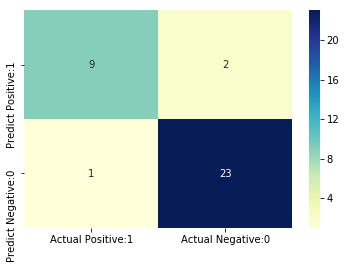

In [276]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [283]:
x_train_re =df_train.drop(['id', 'dataset', 'overall_survival_in_days','recurrence_metastatic_free_survival_in_days'], axis=1)
x_test_re =df_test.drop(['id', 'dataset', 'overall_survival_in_days','recurrence_metastatic_free_survival_in_days'], axis=1)
Y_train_re = df_train["recurrence_metastatic_free_survival_in_days"]
Y_test_re = df_test["recurrence_metastatic_free_survival_in_days"]
Y_train_re = (Y_train_re > 1825)
Y_test_re = (Y_test_re > 1825)
X_train_re = sc.fit_transform(x_train_re)
X_test_re= sc.transform(x_test_re)
scaled_x_train_re = pd.DataFrame(X_train_re , index=x_train_re.index, columns=x_train_re.columns)
scaled_x_test_re = pd.DataFrame(X_test_re , index=x_test_re.index, columns=x_test_re.columns)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [284]:
logmodel=LogisticRegression(random_state = 42,max_iter= 150)
classification_model(logmodel,df_train,scaled_x_train_re,Y_train_re)
predictions = logmodel.predict(scaled_x_test_re)
accuracy = accuracy_score(predictions,Y_test_re)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 98.039%
Cross-Validation Score : 95.238%
Cross-Validation Score : 92.857%
Cross-Validation Score : 90.238%
Cross-Validation Score : 91.429%
Cross-Validation Score : 92.143%
Accuracy : 88.571%


d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-pa

In [285]:
svmr= svm.SVC(kernel='rbf')
classification_model(svmr,df_train,scaled_x_train_re,Y_train_re)
predictions = svmr.predict(scaled_x_test_re)
accuracy = accuracy_score(predictions,Y_test_re)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 98.039%
Cross-Validation Score : 95.238%
Cross-Validation Score : 95.238%
Cross-Validation Score : 93.492%
Cross-Validation Score : 93.869%
Cross-Validation Score : 94.095%
Accuracy : 85.714%


d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change f

In [287]:
cm = confusion_matrix(logmodel.predict(scaled_x_test_re), Y_test_re)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[21  1]
 [ 3 10]]

True Positives(TP) =  21

True Negatives(TN) =  10

False Positives(FP) =  1

False Negatives(FN) =  3


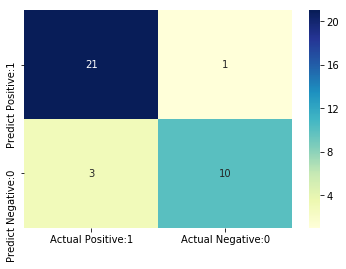

In [288]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')